# Is Software Updated?

This notebook looks at references to GitHub URLs in papers available in the OA corpus from EuroPMC,
and identifies:

  * How many times the GitHub repositories have been updated since paper referencing them was released
  
Note that at present, we are not distinguishing between URLs referencing software *created* by the paper authors,
versus *used* by the authors, nor which software was created as a result of the work in the paper.

In [76]:
import pandas
import json
from datetime import datetime, timedelta
from collections import defaultdict
from github import Github
import numpy as np
import matplotlib.pyplot as plt

import process_eupmc
import process_urls

## File locations

In [2]:
# Directory containing the data
data_dir = '../data'

# File containing the list of matching papers
matching_papers = data_dir + '/' + 'eupmc_fulltext_html_urls.txt'

# File for the output
output_jsonfile = data_dir + '/' + 'dict_of_papers.json'

# Github Token
gh_token = '../secrets/github_token'

In [35]:
with open(gh_token, 'r') as f:
    github_token = f.read().rstrip()

## Use getpapers to download fulltext of papers

We currently do this outside of the notebook, and assume that the files are available locally.

The command we are using is:

>getpapers --query 'github' -x --limit 100 -o data

which queries EuPMC for all papers containing the term 'github' and returns the full text of the first 100 papers matching this into the directory 'data'

## Textmine each paper

In [3]:
# Get the list of subdirectories dumped by ContentMine
paper_ids = process_eupmc.get_pmcids(matching_papers)

In [4]:
# Process the papers and extract all the references to GitHub and Zenodo urls
papers_info = process_eupmc.process_papers(paper_ids, data_dir)

## Analyse GitHub repos to see frequency of commits

In [103]:
g = Github(github_token)
number_of_updates = defaultdict(int)
frequency_of_updates = defaultdict(int)

for p in papers_info:

    repos = []
    # The following removes references to the main github.com site
    # and also treats references to blobs / issues as references to the repo
    for gh_url in p.references['github']:
        words = gh_url.split('/')
        if len(words) > 4: #
            reponame = words[3] + '/' + words[4]
            if reponame not in repos:
                repos.append(reponame)            
    
    for repo in repos:
        print ("Processing: ", repo)
        code = g.get_repo(repo)
        # limit to commits since publication date
        since = datetime.strptime(p.pub_date, '%Y-%m-%d')
        days = (datetime.now() - since).days
        commits = code.get_commits()
        num_commits = 0
        commit_date = commits[num_commits].commit.author.date
        while commit_date > since:
            num_commits = num_commits + 1
            commit_date = commits[num_commits].commit.author.date
        print("Number of commits since publication: ", num_commits)
        commit_freq = num_commits / days
        print("Commit frequency: ", commit_freq, "commits/day since publication")
        number_of_updates[num_commits] +=1
        # I'm using the magic number 100 until I get a sense of the correct bins to use
        frequency_of_updates[int(100 * commit_freq)] +=1

Processing:  theislab/Scanpy
Number of commits since publication:  176
Commit frequency:  2.8852459016393444 commits/day since publication
Processing:  theislab/anndata
Number of commits since publication:  57
Commit frequency:  0.9344262295081968 commits/day since publication
Processing:  theislab/scanpy_usage
Number of commits since publication:  25
Commit frequency:  0.4098360655737705 commits/day since publication
Processing:  linnarsson-lab/loompy
Number of commits since publication:  34
Commit frequency:  0.5573770491803278 commits/day since publication
Processing:  PMBio/scLVM
Number of commits since publication:  0
Commit frequency:  0.0 commits/day since publication
Processing:  YosefLab/FastProject
Number of commits since publication:  0
Commit frequency:  0.0 commits/day since publication
Processing:  AllonKleinLab/SPRING
Number of commits since publication:  5
Commit frequency:  0.08196721311475409 commits/day since publication
Processing:  dimenwarper/scimitar
Number of co

## Plotting the results

We use a defaultdict so that we can easily zero entries with no data.

In [104]:
frequency_of_updates

defaultdict(int,
            {0: 51,
             1: 7,
             2: 3,
             3: 3,
             4: 1,
             5: 1,
             6: 2,
             7: 3,
             8: 1,
             13: 2,
             14: 1,
             21: 1,
             22: 2,
             40: 1,
             55: 1,
             58: 1,
             78: 1,
             93: 1,
             101: 1,
             288: 2,
             990: 1,
             1012: 1})

In [125]:
most_frequent = max(frequency_of_updates, key=int)
x_values = []
y_values = []

for i in frequency_of_updates:
    # I'm using the magic number 100 until I get a sense of the correct bins to use
    x_values.append(i / 100)
    y_values.append(frequency_of_updates[i])

In [ ]:
plt.plot(x_values, y_values)
plt.suptitle('Does software referenced in publications get updated?')
plt.xlabel('Commits/day since publication date')
plt.ylabel('Number of GitHub repositories')

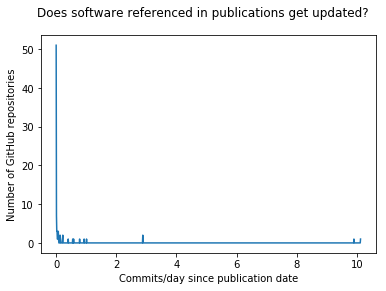

In [129]:
plt.show()

In [87]:
most_commits = max(number_of_updates, key=int)

for i in range(most_commits):
    if i not in number_of_updates:
        number_of_updates[i] = 0

In [ ]:
plt.bar(range(len(number_of_updates)), list(number_of_updates.values()), align='center')
plt.suptitle('Does software referenced in publications get updated?')
plt.xlabel('Number of commits since publication date')
plt.ylabel('Number of GitHub repositories')

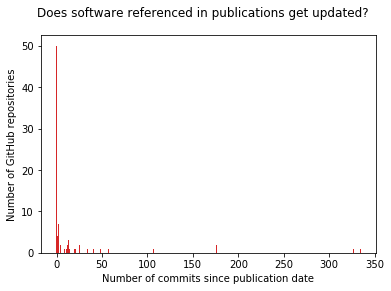

In [97]:
plt.show()

## Caveats to these plots

1. They does not distinguish between software created by the publication author and software referenced by the author